# Практическое задание 1. Обучение полносвязной нейронной сети.

In [134]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных (0 баллов)

Если вам требуется работать с каким-нибудь набором данных (dataset), то, прежде всего, проверьте, нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [135]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [136]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   t10k-labels-idx1-ubyte.gz   train-labels-idx1-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte     train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte	   train-images-idx3-ubyte.gz


In [137]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`.

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [138]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None,
                 label_transform=None):
        if train:
            images, labels = load_mnist(os.path.join(path,"raw"))
        else:
            images, labels = load_mnist(os.path.join(path,"raw"), kind="t10k")

        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################

        self.images = images.astype(np.float32).reshape(-1, 28, 28)  # (num_samples, 28, 28)
        self.labels = labels.astype(np.int64)  # Преобразование меток в целые числа

        self.image_transform = image_transform
        self.label_transform = label_transform

        self.classes = [
            "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]

    def __len__(self,):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return len(self.labels)

    def __getitem__(self, idx):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        img = self.images[idx]
        label = self.labels[idx]
        if self.image_transform:
            img = self.image_transform(img)
        if self.label_transform:
            label = self.label_transform(np.array(label))
        return img, label


In [139]:
test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

In [140]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Визуализируйте случайные элементы набора данных.

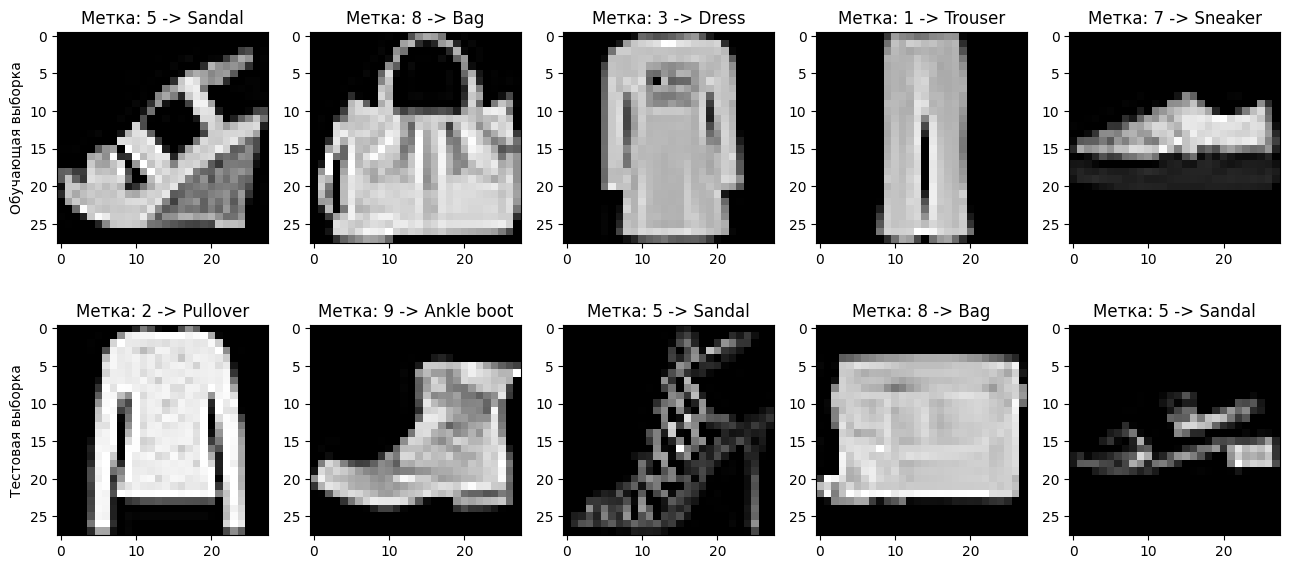

In [141]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
fig, axes = plt.subplots(2, 5, figsize=(13, 6))

for idx, ds in enumerate((train_dataset, test_dataset)):
    for jdx, kdx in enumerate(np.random.randint(0, len(ds), size=5)):
        image, label = ds[kdx]
        axes[idx, jdx].imshow(image / 255.0, cmap='gray')
        axes[idx, jdx].set_title(f'Метка: {label} -> {ds.classes[label]}')

axes[0, 0].set_ylabel('Обучающая выборка')
axes[1, 0].set_ylabel('Тестовая выборка')

fig.tight_layout()
plt.show()

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [142]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample)

In [143]:
transform = ToTensor()

test_dataset = FashionMnist("data/FashionMNIST",
                            train=False,
                            image_transform=transform,
                            label_transform=transform
                            )
train_dataset = FashionMnist("data/FashionMNIST",
                             image_transform=transform,
                             label_transform=transform
                             )

In [144]:
print(f"The type of the data is {type(test_dataset[0][0])}")

The type of the data is <class 'torch.Tensor'>


Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [145]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [146]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [147]:
def collate(batch):
    ###########################################################
    ############# YOUR CODE HERE ##############################
    ###########################################################
    imgs = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    imgs = torch.stack(imgs)
    labels = torch.tensor(labels)
    return imgs, labels

Убедитесть, что все работает корректно.

In [148]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2,
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2,
                              shuffle=True, collate_fn=collate)
batch = next(iter(test_dataloader))

In [149]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


## 2. Реализация модулей нейронной сети (15 баллов)

В этом разделе мы полностью реализуем модули для полносвязанной сети.

Для начала нам понадобится реализовать прямой и обратный проход через слои.

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [150]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [151]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU (1 балл)
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [152]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        ctx.save_for_backward(input)
        output = torch.where(input > 0, input, 0)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input


In [153]:
class ReLU(nn.Module):
    def __init__(self):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        super().__init__()
        self.relu = ReLUFunction.apply
        return


    def forward(self, input):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.relu(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [154]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
relu = ReLUFunction.apply
x = torch.randn(5, 5, dtype=torch.double, requires_grad=True)

assert gradcheck(relu, x)

In [155]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
our_relu = ReLU()
torch_relu = nn.ReLU()
x = torch.randn(5, 5, dtype=torch.float, requires_grad=True)

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected) (3 балла)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [156]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        ctx.save_for_backward(inp, weight, bias)
        output = inp @ weight.T + bias

        return output

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        inp, weight, bias = ctx.saved_tensors

        grad_bias = grad_output.sum(dim=0)
        grad_input = grad_output @ weight
        grad_weight = grad_output.T @ inp

        return grad_input, grad_weight, grad_bias

In [157]:
class Linear(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()
        # initialize weights with small random numbers from normal distribution

        #self.weight = nn.Parameter(torch.randn(output_units, input_units) / torch.sqrt(torch.tensor(input_units, dtype=torch.float32)))
        #self.bias = nn.Parameter(torch.randn(output_units, dtype=torch.float32))
        #self.weight = nn.Parameter(nn.init.xavier_uniform_(weight, gain=nn.init.calculate_gain('relu')))

        weight = torch.empty(output_units, input_units, dtype=torch.float32)
        bias = torch.empty(output_units, dtype=torch.float32)

        self.weight = nn.Parameter(nn.init.sparse_(weight, sparsity=0.05))
        self.bias = nn.Parameter(nn.init.constant_(bias, 0.0))
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        self.linear = LinearFunction.apply
        return

    def forward(self,inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.linear(inp, self.weight, self.bias)

Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [158]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
input_units = 784
output_units = 10

linear = LinearFunction.apply

x = torch.randn(32, input_units, dtype=torch.double, requires_grad=True)
weight = torch.randn(output_units, input_units, dtype=torch.double, requires_grad=True)
bias = torch.randn(output_units, dtype=torch.double, requires_grad=True)

assert gradcheck(linear, (x, weight, bias))

Сравнение с `PyTorch`.

In [159]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
input_units = 784
output_units = 10

our_linear = Linear(input_units, output_units)
torch_linear = nn.Linear(input_units, output_units, bias=True)

x = torch.randn(32, input_units, dtype=torch.float32, requires_grad=True)
weight = torch.randn(output_units, input_units, dtype=torch.float32, requires_grad=True)
bias = torch.randn(output_units, dtype=torch.float32, requires_grad=True)

state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)

###########################################################
############# YOUR CODE HERE ##############################
###########################################################
assert torch.norm(torch_linear(x) - our_linear(x)) < 1e-4

### 2.3 LogSoftmax (Log + Softmax) (4 балла)

Для решения задачи многоклассовой классификации обычно используют `softmax` в качестве нелинейности на последнем слое, чтобы получить "оценку" вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуйте слой `LogSoftmax` (без параметров). Метод `forward` должен вычислять логарифм от `softmax`, а метод `backward` - пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент `grad_output` - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

Для полного балла нужна имплементация с `Log-Sum-Exp trick`.

In [160]:
class LogSoftmaxFunction(Function):
    @staticmethod
    def forward(ctx, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        max_val, _ = torch.max(inp, dim=1, keepdim=True)
        stable_inp = inp - max_val
        stable_inp_exp = torch.exp(stable_inp)
        log_sum_exp = torch.log(torch.sum(stable_inp_exp, dim=1, keepdim=True))
        log_softmax = stable_inp - log_sum_exp

        ctx.save_for_backward(log_softmax)

        return log_softmax

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        log_softmax, = ctx.saved_tensors

        output_dim = grad_output.shape[-1]

        softmax = torch.exp(log_softmax)
        softmax_matrix = softmax.unsqueeze(1).repeat(1, output_dim, 1)
        dL_dlogSM = torch.eye(output_dim).to(softmax.device) - softmax_matrix
        grad_input = torch.einsum('ij,ijk->ik', grad_output, dL_dlogSM)

        return grad_input

In [161]:
class LogSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        self.logsoftmax = LogSoftmaxFunction.apply

    def forward(self, input):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.logsoftmax(input)

Проверка градиентов.

In [162]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
logsoftmax = LogSoftmaxFunction.apply

x = torch.randn(32, 10, dtype=torch.double, requires_grad=True)

assert gradcheck(logsoftmax, x)

### 2.4 Dropout (2 балла)
Реализуйте слой Dropout.

In [163]:
class DropoutFunction(Function):
    @staticmethod
    def forward(ctx, inp, p):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        mask = torch.rand_like(inp) #.to(inp.device)
        mask = (mask > p).float()
        out = mask * inp / (1-p)

        ctx.save_for_backward(mask)
        ctx.p = p

        return out

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        mask, = ctx.saved_tensors
        p = ctx.p

        grad_input = grad_output * mask / (1-p)
        return grad_input, None

In [164]:
class Dropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        self.p = p
        self.dropout = DropoutFunction.apply

        return

    def forward(self, input):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        if self.training:
            return DropoutFunction.apply(input, self.p)
        else:
            return input

In [165]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
dropout = DropoutFunction.apply

x = torch.randn(4, 2, dtype=torch.double, requires_grad=True)
p = torch.rand(1, dtype=torch.double, requires_grad=False)

assert gradcheck(dropout, (x, p))

### 2.5 CrossEntropy (5 баллов)

При решении задачи многоклассовой классификации мы будет использовать в качестве функции потерь **кроссэнтропию, совместимую с `LogSoftmax` активацией**.

Реализуйте эту функцию потерь. В разделе 2.3 приведены полезные формулы.

In [166]:
class CrossEntropyFunction(Function):
    @staticmethod
    def forward(ctx, activations, target):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        batch_size = activations.size(0)
        num_classes = activations.size(1)
        ctx.batch_size = batch_size
        ctx.num_classes = num_classes
        ctx.save_for_backward(target)

        loss = -activations.gather(dim=1, index=target.unsqueeze(1)).mean()

        return loss

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        batch_size, num_classes = ctx.batch_size, ctx.num_classes
        target, = ctx.saved_tensors

        grad_input = torch.zeros(size=(batch_size, num_classes)).to(target.device)
        grad_input[torch.arange(batch_size), target] = -1.0 / batch_size

        return grad_output * grad_input, None

class CrossEntropy(nn.Module):
    def __init__(self, ):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        self.crossentropy = CrossEntropyFunction.apply
        return

    def forward(self, activations, target):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.crossentropy(activations, target)

Проверка градиентов.

In [167]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
crossentropy = CrossEntropyFunction.apply

activations = torch.randn(32, 10, dtype=torch.double, requires_grad=True)
target = torch.randint(low=0, high=10, size=(32,), dtype=torch.int64, requires_grad=False)

assert gradcheck(crossentropy, (activations, target))

## 3. Сборка и обучение нейронной сети (5 баллов)

Реализуйте из ваших блоков персептрон и обучите его, залоггировав итоговый лосс и метрику на валидационной выборке. **(1 балл)**

Подсказка: вытягиваем картинку в вектор с помощью [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In [168]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10, dropout_p=0.10):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        layers = []
        layers.append(nn.Flatten())

        if num_layers == 1:
            layers.append(Linear(input_size, num_classes))
        else:
            layers.append(Linear(input_size, hidden_layers_size))
            layers.append(ReLU())
            layers.append(Dropout(dropout_p))

            for _ in range(num_layers - 1):
                layers.append(Linear(hidden_layers_size, hidden_layers_size))
                layers.append(ReLU())
                layers.append(Dropout(dropout_p))

            layers.append(Linear(hidden_layers_size, num_classes))

        layers.append(LogSoftmax())

        self.model = nn.Sequential(*layers)

    def forward(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.model(inp)

    def predict(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        with torch.no_grad():
            output = self.model(inp)
            _, predicted = torch.max(output.data, dim=1)
        return predicted


Ниже приведены функции, реализующие обучение нейронной сети. В данном задании их предлагается просто переиспользовать.

In [169]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [170]:
# accuracy metric for our classififcation
def accuracy(model_labels, labels):
    return torch.mean((model_labels == labels).float())

In [171]:
def perform_epoch(model, loader, criterion,
                optimizer=None, device=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_labels in loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            model_labels = model(batch_data)
            model_prediction = model.predict(batch_data)
            new_loss = criterion(model_labels, batch_labels)
            if is_train:
                optimizer.zero_grad()
                new_loss.backward()
                optimizer.step()

            one_batch_loss = float(criterion(model_labels, batch_labels))
            one_batch_acc = accuracy(model_prediction, batch_labels)

            total_loss += one_batch_loss
            total_acc += one_batch_acc
            total_n += 1
    return (total_loss / total_n, total_acc / total_n)

Теперь обучим нашу нейронную сеть. В данном разделе будем использовать оптимизатор `Adam` с параметрами по умолчанию.

In [172]:
model     = Network()
optimizer = Adam(model.parameters())
criterion = CrossEntropy()

In [173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

print(f'All computations are performed on -> {device} <-')

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

All computations are performed on -> cuda <-
Epoch - 0 : loss 1.0146368581391871, accuracy 0.5792665481567383
Current learning rate: 0.001
Epoch - 1 : loss 0.7120358406975865, accuracy 0.7329463362693787
Current learning rate: 0.001
Epoch - 2 : loss 0.6344780146591366, accuracy 0.7676830291748047
Current learning rate: 0.001
Epoch - 3 : loss 0.5960784279964865, accuracy 0.7840672135353088
Current learning rate: 0.001
Epoch - 4 : loss 0.5791585617233068, accuracy 0.7936177253723145
Current learning rate: 0.001
Epoch - 5 : loss 0.5689124140902423, accuracy 0.7981011867523193
Current learning rate: 0.001
Epoch - 6 : loss 0.549681685837917, accuracy 0.8039682507514954
Current learning rate: 0.001
Epoch - 7 : loss 0.5434142429768107, accuracy 0.8058512210845947
Current learning rate: 0.001
Epoch - 8 : loss 0.5410092983008362, accuracy 0.809584379196167
Current learning rate: 0.001
Epoch - 9 : loss 0.5410941402968019, accuracy 0.8094348907470703
Current learning rate: 0.001


In [174]:
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 0.5410941402968019, accuracy 0.8094348907470703
Current learning rate: 0.001


Дальше **(4 балла)**:
- Проведите эксперименты с числом слоев.
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы.

Training Loop для выполнения этой части задания можно и нужно улучшать, в том числе, добавляя более продвинутое логгирование эксперимента.

Для начала напишем код для проведения экспериментов:

In [177]:
def num_layers_experiment(num_layers_list, train_dataloader, test_dataloader, device, input_size=784, hidden_size=32, num_classes=10, epochs=10, runs=3):
    train_accuracies = {n_layers: [] for n_layers in num_layers_list}
    test_accuracies = {n_layers: [] for n_layers in num_layers_list}

    print(f'All computations are performed on -> {device} <-\n')

    for n_layers in num_layers_list:
        print(f'Num layers - {n_layers} : ')
        for run in range(runs):
            print(f'{(" " * 2)}Run - {run+1} : ')
            model = Network(input_size=input_size, hidden_layers_size=hidden_size, num_layers=n_layers, num_classes=num_classes).to(device)
            criterion = CrossEntropy()
            optimizer = Adam(model.parameters())

            for epoch in range(epochs):
                print(f'{(" " * 4)}Epoch - {epoch+1} : ')
                print(f'{(" " * 6)}Current learning rate: {optimizer.param_groups[0]["lr"]}')
                train_loss, train_acc = perform_epoch(model, train_dataloader, criterion, optimizer, device)
                test_loss, test_acc = perform_epoch(model, test_dataloader, criterion, device=device)

                train_accuracies[n_layers].append(train_acc)
                test_accuracies[n_layers].append(test_acc)

                print(f'{(" " * 6)}train loss: {train_loss:.4f}, train accuracy: {train_acc:.4f}')
                print(f'{(" " * 6)}test loss: {test_loss:.4f}, test accuracy: {test_acc:.4f}')

        print('\n')

    return train_accuracies, test_accuracies

In [179]:
num_layers = [1,3,5,7,9]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_accuracies, test_accuracies = num_layers_experiment(num_layers_list=num_layers, train_dataloader=train_dataloader, test_dataloader=test_dataloader, device=device)

All computations are performed on -> cuda <-

Num layers - 1 : 
  Run - 1 : 
    Epoch - 1 : 
      Current learning rate: 0.001
      train loss: 14.3873, train accuracy: 0.7612
      test loss: 12.0198, test accuracy: 0.7911
    Epoch - 2 : 
      Current learning rate: 0.001
      train loss: 15.1535, train accuracy: 0.7892
      test loss: 13.7214, test accuracy: 0.7880
    Epoch - 3 : 
      Current learning rate: 0.001
      train loss: 14.8658, train accuracy: 0.7970
      test loss: 17.7111, test accuracy: 0.7868
    Epoch - 4 : 
      Current learning rate: 0.001
      train loss: 15.2440, train accuracy: 0.7964
      test loss: 14.1196, test accuracy: 0.8049
    Epoch - 5 : 
      Current learning rate: 0.001
      train loss: 14.8777, train accuracy: 0.8027
      test loss: 17.3874, test accuracy: 0.8038
    Epoch - 6 : 
      Current learning rate: 0.001
      train loss: 14.9612, train accuracy: 0.8042
      test loss: 14.0429, test accuracy: 0.8085
    Epoch - 7 : 
      

In [191]:
final_train_accuracies = {key: values[9::10] for key, values in train_accuracies.items()}
final_test_accuracies = {key: values[9::10] for key, values in test_accuracies.items()}
final_train_accuracies, final_test_accuracies

({1: [tensor(0.8090, device='cuda:0'),
   tensor(0.8060, device='cuda:0'),
   tensor(0.8056, device='cuda:0')],
  3: [tensor(0.8243, device='cuda:0'),
   tensor(0.8203, device='cuda:0'),
   tensor(0.8351, device='cuda:0')],
  5: [tensor(0.8092, device='cuda:0'),
   tensor(0.8044, device='cuda:0'),
   tensor(0.8075, device='cuda:0')],
  7: [tensor(0.7933, device='cuda:0'),
   tensor(0.7634, device='cuda:0'),
   tensor(0.7888, device='cuda:0')],
  9: [tensor(0.0995, device='cuda:0'),
   tensor(0.0990, device='cuda:0'),
   tensor(0.0993, device='cuda:0')]},
 {1: [tensor(0.8114, device='cuda:0'),
   tensor(0.7689, device='cuda:0'),
   tensor(0.8130, device='cuda:0')],
  3: [tensor(0.8426, device='cuda:0'),
   tensor(0.8102, device='cuda:0'),
   tensor(0.8407, device='cuda:0')],
  5: [tensor(0.8286, device='cuda:0'),
   tensor(0.8282, device='cuda:0'),
   tensor(0.8249, device='cuda:0')],
  7: [tensor(0.8129, device='cuda:0'),
   tensor(0.7850, device='cuda:0'),
   tensor(0.8089, device='cu

In [199]:
def plot_boxplots(train_accuracies, test_accuracies, num_layers):
    train_data = [torch.tensor(accuracies).cpu().numpy() for accuracies in train_accuracies.values()]
    test_data = [torch.tensor(accuracies).cpu().numpy() for accuracies in test_accuracies.values()]

    plt.figure(figsize=(12, 6))

    # Создание боксплота для тренировочных данных
    plt.subplot(1, 2, 1)
    plt.boxplot(train_data, labels=train_accuracies.keys())
    plt.title('Train Accuracies')
    plt.xlabel('Number of linear layers')
    plt.ylabel('Accuracy')

    # Создание боксплота для тестовых данных
    plt.subplot(1, 2, 2)
    plt.boxplot(test_data, labels=test_accuracies.keys())
    plt.title('Test Accuracies')
    plt.xlabel('Number of linear layers')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

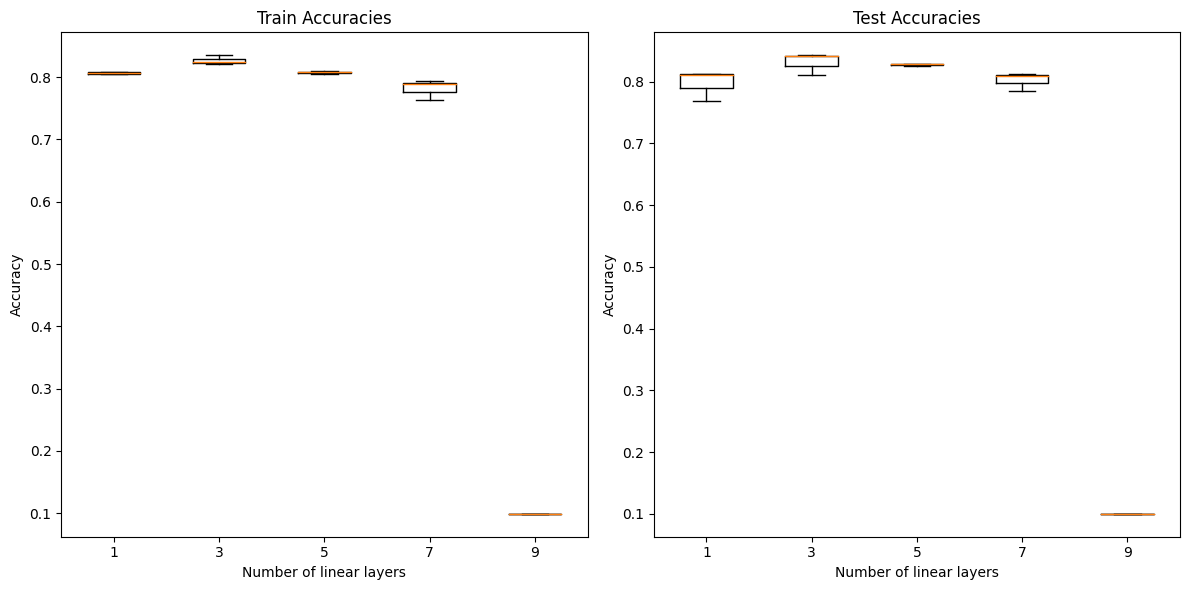

In [200]:
plot_boxplots(final_train_accuracies, final_test_accuracies, num_layers)

### Итоги:
Как видно из проведенных экспериментов для данной задачи с заданной архитектурой максимальная точность достигается при количестве слоев в диапазоне [3;5]. Максимальная точность равна при этом примерно 80-83%.

Также заметим, что при 9 слоях модель работает на уровне constant модели (и даже немного хуже), что говорит нам о том, что избыточное число слоев может привести к снижению качества.

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (3 + 3 балла).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam.

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание.

In [203]:
class SGDMomentum(Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9):
        defaults = dict(lr=lr, momentum=momentum)
        super(SGDMomentum, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGDMomentum, self).__setstate__(state)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']

            for p in group['params']:
                if p.grad is not None:
                    grad = p.grad
                    state = self.state[p]

                    if len(state) == 0:
                        state['momentum_buffer'] = torch.zeros_like(p)

                    momentum_buffer = state['momentum_buffer']
                    momentum_buffer.mul_(momentum).add_(grad)
                    p.data.add_(-lr * momentum_buffer)

### 4.2 Реализация современной функции активации (2 + 2 балла).
Реализуйте одну из активаций, предложенных на лекции или в статье. Например, `Hardswish`. Сравните сеть с вашей активацией и с `ReLU`.

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание.

Я хочу реализовать функцию активации Mish. Формулу для градиентов я взял здесь: https://www.kaggle.com/code/samuelcortinhas/mish-a-self-regularized-activation-function-tf

In [184]:
class MishFunction(Function):
    @staticmethod
    def forward(ctx, input):
        output = input * torch.tanh(torch.log(1+torch.exp(input)))

        ctx.save_for_backward(input, output) # сохраняем значение input, Mish
        return output

    @staticmethod
    def backward(ctx, grad_output):
        def swish(x):
            return x*torch.sigmoid(x)

        def softplus(x):
            return torch.log(1+torch.exp(x))

        def sech(x):
            return 1 / torch.cosh(x)

        input, mish = ctx.saved_tensors

        grad_input = grad_output * (mish / input + swish(input) * (sech(softplus(input)))**2)

        return grad_input

In [185]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        self.mish = MishFunction.apply

    def forward(self, input):
        return self.mish(input)

Проверка градиентов.

In [188]:
###########################################################
############# YOUR CODE HERE ##############################
###########################################################
mish = MishFunction.apply
x = torch.randn(5, 5, dtype=torch.double, requires_grad=True)

assert gradcheck(mish, x)

### Теперь после проведения экспериментов и написания собственных оптимизатора и функции активации давайте посмотрим на качество модели с кастомными SGDWithMomentum и Mish с количеством слоев равным 4.

In [202]:
class Network_upgrade(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10, dropout_p=0.10):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        layers = []
        layers.append(nn.Flatten())

        layers.append(Linear(input_size, hidden_layers_size))
        layers.append(Mish())
        layers.append(Dropout(dropout_p))

        for _ in range(num_layers - 1):
            layers.append(Linear(hidden_layers_size, hidden_layers_size))
            layers.append(Mish())
            layers.append(Dropout(dropout_p))

        layers.append(Linear(hidden_layers_size, num_classes))

        layers.append(LogSoftmax())

        self.model = nn.Sequential(*layers)

    def forward(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.model(inp)

    def predict(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        with torch.no_grad():
            output = self.model(inp)
            _, predicted = torch.max(output.data, dim=1)
        return predicted


Сначала проверим работу Mish:

In [208]:
model     = Network_upgrade(num_layers=4)
optimizer = Adam(model.parameters())
criterion = CrossEntropy()

In [209]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

print(f'All computations are performed on -> {device} <-')

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

All computations are performed on -> cuda <-
Epoch - 0 : loss 0.8739906604513525, accuracy 0.6514907479286194
Current learning rate: 0.001
Epoch - 1 : loss 0.5880376022066921, accuracy 0.7867823839187622
Current learning rate: 0.001
Epoch - 2 : loss 0.5379546659709886, accuracy 0.809283971786499
Current learning rate: 0.001
Epoch - 3 : loss 0.5093687990913167, accuracy 0.8195677399635315
Current learning rate: 0.001
Epoch - 4 : loss 0.49991301318304615, accuracy 0.8265852332115173
Current learning rate: 0.001
Epoch - 5 : loss 0.48940597186330703, accuracy 0.8307013511657715
Current learning rate: 0.001
Epoch - 6 : loss 0.47936925679584963, accuracy 0.8319512605667114
Current learning rate: 0.001
Epoch - 7 : loss 0.47819988937769087, accuracy 0.8340516686439514
Current learning rate: 0.001
Epoch - 8 : loss 0.4749810936120339, accuracy 0.834884524345398
Current learning rate: 0.001
Epoch - 9 : loss 0.47220744033670053, accuracy 0.8346513509750366
Current learning rate: 0.001


Как мы видим, функция активации Mish прекрасно себя показала,  незначительно увеличив качество модели относительно функции активации ReLU.

Давайте теперь для наглядности посмотрим, как наша модель предсказывает картинки:

In [210]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('model.1.weight', tensor([[ 0.0518, -0.1895, -0.3083,  ..., -0.2324, -0.2207, -0.1657],
        [ 0.1568,  0.0196,  0.1149,  ..., -0.2531,  0.1563,  0.1488],
        [-0.0330,  0.2241,  0.4829,  ...,  0.3662,  0.4246,  0.4893],
        ...,
        [-0.0242, -0.0397, -0.0390,  ..., -0.1476, -0.0447, -0.0486],
        [ 0.0403,  0.0820,  0.2157,  ..., -0.0554, -0.1613, -0.0231],
        [-0.0620,  0.1630,  0.1286,  ...,  0.2794,  0.2266,  0.0667]],
       device='cuda:0')), ('model.1.bias', tensor([-0.5842, -0.1433,  0.3550, -0.0025,  0.6317, -0.6585, -1.1352,  0.9264,
        -0.0098, -0.3943,  0.3121, -0.7469,  0.3576, -0.0049,  0.6370, -0.9626,
        -0.4632, -1.5060, -0.0911, -0.9395, -0.0075, -0.0054, -0.2626,  0.4931,
        -0.2596,  0.2754, -0.0057, -0.5578, -0.1719,  0.2261,  0.2754,  0.3737],
       device='cuda:0')), ('model.4.weight', tensor([[-0.1314, -0.1349, -0.3608,  ..., -0.1153, -0.1996, -0.4542],
        [ 0.0521, -0.1728, -0.0561,  ..., -0.1115,  0.1

Сохраним веса на будущее.

In [211]:
torch.save(state_dict, 'upgrade_model_weights.pt')

<ipython-input-212-7a59703ac0da>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('upgrade_model_weights.pt')


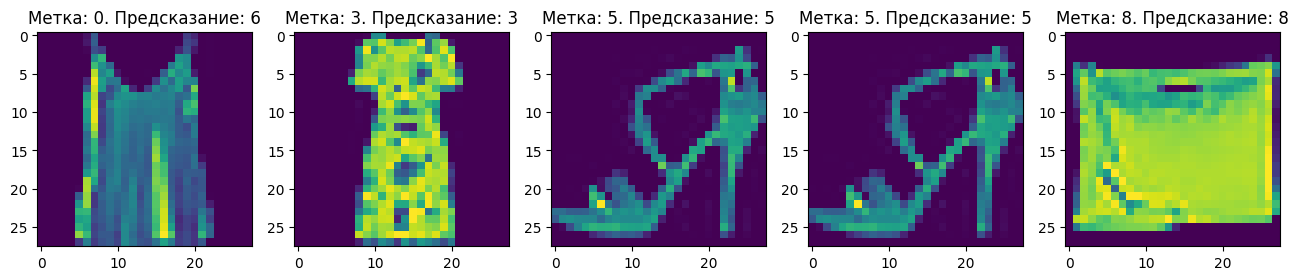

In [212]:
state_dict = torch.load('upgrade_model_weights.pt')

network = Network_upgrade(num_layers=4)
network.load_state_dict(state_dict)

images, labels = next(iter(test_dataloader))

logits = network(images)
predictions = torch.argmax(logits, dim=1)

fig, axes = plt.subplots(1, 5, figsize=(13, 4))
for idx, jdx in enumerate(np.random.randint(0, len(images), size=5)):
    axes[idx].imshow(images[jdx])
    axes[idx].set_title(f'Метка: {labels[jdx]}. Предсказание: {predictions[jdx]}')

fig.tight_layout()
plt.show()

Как мы видим модель неплохо справляется. Из предложенных на данный момент картинок модель перепутала только майку с футболкой (что в целом тоже не очень плохо).

И в конце, протестируем кастомный оптимизатор:

In [213]:
model     = Network_upgrade(num_layers=4)
optimizer = SGDMomentum(model.parameters())
criterion = CrossEntropy()

In [214]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

print(f'All computations are performed on -> {device} <-')

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

All computations are performed on -> cuda <-
Epoch - 0 : loss 2.2774308345615863, accuracy 0.10931799560785294
Current learning rate: 0.001
Epoch - 1 : loss 1.0644931816384195, accuracy 0.5865010619163513
Current learning rate: 0.001
Epoch - 2 : loss 0.646740694116801, accuracy 0.7596807479858398
Current learning rate: 0.001
Epoch - 3 : loss 0.5646151374522597, accuracy 0.8004667162895203
Current learning rate: 0.001
Epoch - 4 : loss 0.5256340730991215, accuracy 0.8169510960578918
Current learning rate: 0.001
Epoch - 5 : loss 0.5004987895339728, accuracy 0.8237513303756714
Current learning rate: 0.001
Epoch - 6 : loss 0.4868615015486721, accuracy 0.8297179341316223
Current learning rate: 0.001
Epoch - 7 : loss 0.4765984620670788, accuracy 0.8308687210083008
Current learning rate: 0.001
Epoch - 8 : loss 0.4659007742987014, accuracy 0.8367679119110107
Current learning rate: 0.001
Epoch - 9 : loss 0.457582775676623, accuracy 0.839118480682373
Current learning rate: 0.001


## Итоги:

Как мы видим, оптимизатор тоже показал себя отлично. Моя модель с кастомными функцией активации Mish и оптимизатором с моментумом для накопления градиентов по качеству совсем немного, но побила лучший скор, что не может не радовать :)

# УРА ПОБЕДА КОНЕЦ ДОМАШКИ!!! СПАСИБО ЗА ЦЕННЫЙ ОПЫТ!!!